In [17]:
# @title Loading Data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab_Notebooks/lorentz_long_x.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# @title Loading Optuna

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

Data length: 1048575


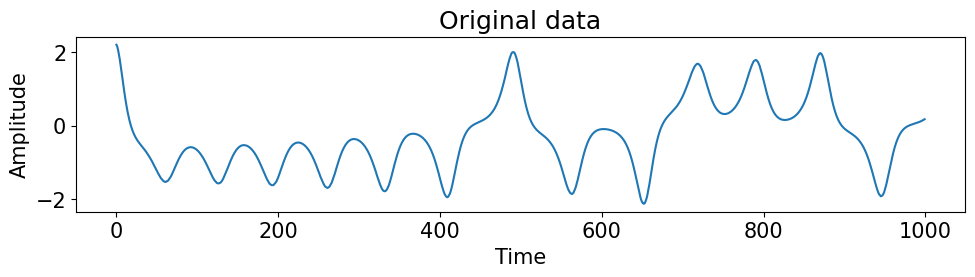

In [19]:
# @title Data standardization

import matplotlib.pyplot as plt
#import numpy as np
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv


nan_indices = np.where(np.isnan(data))

data = np.delete(data, nan_indices)

mean_value = np.mean(data)
std_dev = np.std(data)

# standardization
data = (data - mean_value) / std_dev

print('Data length:',data.size)

##############
#Visualization

t = np.arange(0, data.size, 1)
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(data[:1000])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

# Peephole LSTM with Bayesian Gradient Descent

uniformly random matrix: $W_{datain}, W_{dataforget},W_{dataout},W_{datacell}\in [-input\_scale,input_\_scale]^{N\times d}\ $($d\ll N$)

uniformly random matrix with density: $W_{gatein},W_{forget},W_{gateout},W_{cell}\in[-input\_scale,input\_scale]^{N\times N}\ $ ($input\_scale>0$)


*    Original data $d_t\in\mathbb{R}$ ($t\in\mathbb{Z}$)

*    Input gate $i_t$,

*    Forget gate $f_t$

*    Output gate $o_t$

*    Memory cell $c_t$

*    Sigmoid function $h$

\begin{equation*}
\begin{split}
i_t&=h(W_{datain}d_t+W_{gatein}c_{t-1}+bias),\\
f_t&=h(W_{dataforget}d_t+W_{forget}c_{t-1}+bias),\\
o_t&=h(W_{dataout}d_t+W_{gateout}c_{t-1}+bias),\\
%\tilde c_t&=
\end{split}
\end{equation*}
\begin{equation*}
c_t=input_t\odot \tanh(W_{datacell}d_t+W_{cell}c_{t-1}+bias)+forget_t\odot c_{t-1}
\end{equation*}
\begin{equation*}
x_t=output_t\odot\tanh(cell_t)
\end{equation*}

The operator $\odot$ denotes the element-wise product.
By Ridge regression (using convexity), first we figure out the following $W_{out}$:
\begin{equation*}
d_{t+1} \simeq W_{out} x_t\qquad(\text{the idea of Reservoir}).
\end{equation*}
But in my experience, for the low-dimensional time series prediction, the following Ridge regression is better (we may not need the output gate):
\begin{equation*}
d_{t+1} \simeq W_{out} c_t.
\end{equation*}
After Ridge regression, we apply the Bayesian optimization (Optuna) for minimizing the following objective function (RMSE):
\begin{equation*}
\left(\frac{1}{T}\sum_{t=0}^{T-1}|d_{t+1}-W_{out}c_t|^2\right)^{1/2}.
\end{equation*}

In [20]:
# @title Definition of Peephole LSTM

#################
#input weight matrix
#################
def input_matrix(N_x,seed_value,input_scale,dim):

 #This generates random matrix that can be reproduced by the random number

    # Separate integer and decimal portions
    seed_int_low = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction = seed_value - seed_int_low



    # Random number generation based on integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

    # linear interpolation
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix


##############################
# Generate recurrent weight matrix
##############################

def make_connection(N_x, density, rho,seed_value):

        m = int(N_x*(N_x-1)*density/2) # Setting the number of non-zero components

# Separate integer and decimal portions
        seed_int_low = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction = seed_value - seed_int_low

# Graph generation based on integer part
        graph_low =  nx.gnm_random_graph(N_x, m, seed_int_low)
        graph_high =  nx.gnm_random_graph(N_x, m, seed_int_high)

# Get Edge List
        edges_low = set(graph_low.edges())
        edges_high = set(graph_high.edges())

# Separate common edges from different edges
        common_edges = edges_low & edges_high
        only_low_edges = edges_low - edges_high
        only_high_edges = edges_high - edges_low

# Edge interpolation
        num_only_low_edges = len(only_low_edges)
        num_only_high_edges = len(only_high_edges)

        num_edges_to_add_from_high = round(fraction * num_only_high_edges)
        num_edges_to_remove_from_low =round(fraction * num_only_low_edges)

# Building New Edge Sets
        interpolated_edges = list(common_edges)
        interpolated_edges += list(only_low_edges)[:(num_only_low_edges - num_edges_to_remove_from_low)]
        interpolated_edges += list(only_high_edges)[:num_edges_to_add_from_high]

# Generate a new graph
        interpolated_graph = nx.Graph()
        interpolated_graph.add_nodes_from(range(N_x))
        interpolated_graph.add_edges_from(interpolated_edges)

# Convert graph to matrix
        interpolated_matrix = nx.to_numpy_array(interpolated_graph)
        W = np.asarray(interpolated_matrix)

####################################
#Set recurrent weight matrix so that
#the nonzero portion is continuous with respect to the random seed

        rec_scale = 1.0

# Separate integer and decimal portions
        seed_int_low = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction = seed_value - seed_int_low


# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# linear interpolation
        interpolated_matrix_value = (1 - fraction) * random_matrix_low + fraction * random_matrix_high
        W *= interpolated_matrix_value

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W

####################
def sigmoid(x):

    return 1 / (1 + np.exp(-x))


def Reservoir(x_in,x,W,bias_scale):

        Wbias = np.ones(len(x_in))
        Wbias = Wbias * bias_scale

        x =  np.tanh(np.dot(W, x) + x_in+Wbias)
        return x

def Gate(x_in,x,W,bias_scale):

        Wbias = np.ones(len(x_in))
        Wbias = Wbias * bias_scale

        x =  sigmoid(np.dot(W, x) + x_in+Wbias)
        return x

##############
#Peephole LSTM
##############

    #x is the hidden state vector, c is the cell state vector

def LSTM(x,c,x_gatein,Wgatein,x_cell,Wcell,x_forget,Wforget,x_gateout,Wgateout,gate_bias_scale,reservoir_bias_scale):

        c = Gate(x_gatein,c,Wgatein,gate_bias_scale) * Reservoir(x_cell,c,Wcell,reservoir_bias_scale) +Gate(x_forget,c,Wforget,gate_bias_scale) *c #Peephole

        x = Gate(x_gateout,c,Wgateout,gate_bias_scale) * np.tanh(c) #Peephole

        return x,c



####################
#Definition of Ridge Regression and Generation of Output Weight Matrix
####################
def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

def get_Wout_opt(X_XT,D_XT,N_x,beta):

        #X_pseudo_inv = np.linalg.inv(X_XT + beta * np.identity(N_x))
        #Wout_opt = np.dot(D_XT, X_pseudo_inv)
        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x,c, T_train,Wdatain,Wgatein,Wdatacell,Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len,gate_bias_scale,reservoir_bias_scale):

    x = np.zeros(N_x)
    c = np.zeros(N_x)
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))


    for n in range(T_train):

        x,c = LSTM(x,c,np.dot(Wdatain,train_U[n,:]),Wgatein, np.dot(Wdatacell,train_U[n,:]), \
                   Wcell,np.dot(Wdataforget,train_U[n,:]),Wforget,np.dot(Wdataout,train_U[n,:]),Wgateout,gate_bias_scale,reservoir_bias_scale)


            # teacher data
        d = train_D[n,:]


        if n > discard_len:  # The first data is not learned

            ##X_XT, D_XT = Ridge(d, x, X_XT, D_XT) ##If we employ output gate, use this!!
            X_XT, D_XT = Ridge(d, c, X_XT, D_XT)



    return X_XT, D_XT,x,c


########################
#Induction for creating estimated data
########################

def run(test_U,x,c,Wdatain,Wgatein,Wdatacell,Wcell,Wdataforget,Wforget, Wdataout,Wgateout,Wout,T_test,gate_bias_scale,reservoir_bias_scale):


    Y_pred = []
    y = test_U[0,:]

    for n in range(T_test):

        x,c = LSTM(x,c,np.dot(Wdatain,y),Wgatein, np.dot(Wdatacell,y), \
                   Wcell,np.dot(Wdataforget,y),Wforget,np.dot(Wdataout,y),Wgateout,gate_bias_scale,reservoir_bias_scale)

        ##y_pred = np.dot(Wout, x) ##If we employ output gate, use this!!
        y_pred = np.dot(Wout, c)
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

#######################
#Definition of autocorrelation
#######################

def correlation(data1_in, data2_in):

    mean1 = np.mean(data1_in[:])
    mean2 = np.mean(data2_in[:])
    numerator = np.sum((data1_in[:] - mean1) * (data2_in[:] - mean2))
    denominator = np.sqrt(np.sum((data1_in[:] - mean1) ** 2)) * np.sqrt(np.sum((data2_in[:] - mean2) ** 2))

    return numerator / denominator

In [21]:
# @title Hyperparameters for Bayesian Grad Descent

n_trials = 100   # Number of times to test with optuna
T_train  = 35000 # Training period
Node     = 500   # LSTM Node

discard_len = 10 # Number of steps not learned at the beginning (not important)

In [22]:
# @title Model Selection（Bayesian Grad Descent）

%%time

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

print(len(data))

# Creation of Optuna studies
study = optuna.create_study(direction="minimize")


# Definition of Objective Function
def objective(trial):
    lag = trial.suggest_int("lag", 3, 10)
    dim = trial.suggest_int("dim", 9, 15)
    N_x = trial.suggest_int("N_x", Node, Node)
    beta = trial.suggest_float("beta", 0.001, 0.001)
    density_gate = trial.suggest_float("density_gate", 0.01, 1)
    density_res = trial.suggest_float("density_res", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1)
    rho_gate = trial.suggest_float("rho_gate", 0, 1)
    rho_res = trial.suggest_float("rho_res", 0.98, 0.98)
    seed_value_datain = trial.suggest_float("seed_value_datain", 0, 100)
    seed_value_gatein = trial.suggest_float("seed_value_gatein", 0, 100)
    seed_value_datacell = trial.suggest_float("seed_value_datacell", 0, 100)
    seed_value_cell = trial.suggest_float("seed_value_cell", 0, 100)
    seed_value_dataforget = trial.suggest_float("seed_value_dataforget", 0, 100)
    seed_value_forget = trial.suggest_float("seed_value_forget", 0, 100)
    seed_value_dataout = trial.suggest_float("seed_value_dataout", 0, 100)
    seed_value_gateout = trial.suggest_float("seed_value_gateout", 0, 100)
    gate_bias_scale = trial.suggest_float("gate_bias_scale", -0.3, 0.3)
    reservoir_bias_scale = trial.suggest_float("reservoir_bias_scale", -0.3, 0.3)

####


    T_0 = T_train + lag * dim



###############
#Matrices are elected by random numbers

    Wdatain    = input_matrix(N_x,seed_value_datain,input_scale,dim)
    Wgatein    = make_connection(N_x, density_gate, rho_gate,seed_value_gatein)
    Wdatacell  = input_matrix(N_x,seed_value_datacell,input_scale,dim)
    Wcell      = make_connection(N_x, density_res, rho_res,seed_value_cell)
    Wdataforget= input_matrix(N_x,seed_value_dataforget,input_scale,dim)
    Wforget    = make_connection(N_x, density_gate, rho_gate,seed_value_forget)
    Wdataout   = input_matrix(N_x,seed_value_dataout,input_scale,dim)
    Wgateout   = make_connection(N_x, density_gate, rho_gate,seed_value_gateout)

###############
#Delay coordinate


    data_delay_train = np.zeros((T_train+1,dim), dtype=float)


    for i in range(dim):

        data_delay_train[:,i] = data[T_0-T_train-i*lag:T_0-i*lag+1]

###############


    train_U = np.zeros((T_train,dim), dtype=float)
    train_D = np.zeros((T_train,dim), dtype=float)

#Training data input
    train_U = data_delay_train[:T_train,:]

#Training data output
    train_D = data_delay_train[1:T_train+1,:]



    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))
    x_special = np.zeros(N_x)
    c_special = np.zeros(N_x)


#Training

    X_XT, D_XT,x_special,c_special = train(train_U,train_D,np.zeros(N_x),np.zeros(N_x), T_train,Wdatain,Wgatein,Wdatacell, \
                                 Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len,gate_bias_scale,reservoir_bias_scale)

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

##############################
#Bayesian Grad Descent
##############################

    pred_D = np.zeros((T_train,dim), dtype=float)
    x = np.zeros(N_x)
    c = np.zeros(N_x)

    for n in range(T_train):

        x,c = LSTM(x,c,np.dot(Wdatain,train_U[n,:]),Wgatein, np.dot(Wdatacell,train_U[n,:]), \
                   Wcell,np.dot(Wdataforget,train_U[n,:]),Wforget,np.dot(Wdataout,train_U[n,:]),Wgateout,gate_bias_scale,reservoir_bias_scale)


        ##pred_D[n,:] = np.dot(Wout, x) ##If we employ output gate, use this!!
        pred_D[n,:] = np.dot(Wout, c)

    return np.sqrt(np.mean((pred_D[discard_len:]-train_D[discard_len:])**2)) #RMSE


###############
#Early stopping

def stop_callback(study, trial):
    if study.best_value < 0.0017:
        study.stop()

###############
# Perform optimization

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials, callbacks=[stop_callback])



# Display of optimization results

print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

lag  = trial.params["lag"]
dim  = trial.params["dim"]
N_x  = trial.params["N_x"]
beta = trial.params["beta"]
density_gate = trial.params["density_gate"]
density_res = trial.params["density_res"]
input_scale = trial.params["input_scale"]
rho_gate         = trial.params["rho_gate"]
rho_res         = trial.params["rho_res"]
seed_value_datain    = trial.params["seed_value_datain"]
seed_value_gatein    = trial.params["seed_value_gatein"]
seed_value_datacell    = trial.params["seed_value_datacell"]
seed_value_cell    = trial.params["seed_value_cell"]
seed_value_dataforget    = trial.params["seed_value_dataforget"]
seed_value_forget    = trial.params["seed_value_forget"]
seed_value_dataout    = trial.params["seed_value_dataout"]
seed_value_gateout    = trial.params["seed_value_gateout"]
gate_bias_scale = trial.params["gate_bias_scale"]
reservoir_bias_scale = trial.params["reservoir_bias_scale"]

[I 2025-02-06 04:54:32,742] A new study created in memory with name: no-name-b7a568b4-d892-49a6-b65e-0d9df4c9bc65
[I 2025-02-06 04:54:32,744] A new study created in memory with name: no-name-cf428f96-dc47-4e94-a7c0-cb169010fb39


1048575


[I 2025-02-06 04:56:27,442] Trial 0 finished with value: 0.0017386670607686377 and parameters: {'lag': 6, 'dim': 10, 'N_x': 500, 'beta': 0.001, 'density_gate': 0.44448272105864434, 'density_res': 0.7478783931055302, 'input_scale': 0.8243136928157967, 'rho_gate': 0.07935319978747091, 'rho_res': 0.98, 'seed_value_datain': 71.46822998822613, 'seed_value_gatein': 85.49546301029122, 'seed_value_datacell': 86.39650985619538, 'seed_value_cell': 42.25919626311636, 'seed_value_dataforget': 21.63575190314613, 'seed_value_forget': 79.30193786526733, 'seed_value_dataout': 46.975288324083266, 'seed_value_gateout': 94.51393783803506, 'gate_bias_scale': -0.13198575489520237, 'reservoir_bias_scale': -0.15268934375620605}. Best is trial 0 with value: 0.0017386670607686377.
<ipython-input-20-896f4d74916b>:109: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
[I 2025-02-06 04:58:27,194] Trial 1 finished with value: 0.6143214814400447 and parameters: {'lag': 8, 'dim': 9, 'N_x': 50

Best trial:
  'params': {'lag': 3, 'dim': 10, 'N_x': 500, 'beta': 0.001, 'density_gate': 0.646675635203483, 'density_res': 0.604405015596362, 'input_scale': 0.571513379125479, 'rho_gate': 0.56905422583166, 'rho_res': 0.98, 'seed_value_datain': 37.54262750460845, 'seed_value_gatein': 97.3629882571318, 'seed_value_datacell': 0.6942379053281544, 'seed_value_cell': 44.40483069927896, 'seed_value_dataforget': 0.9807740881464633, 'seed_value_forget': 56.00105859217857, 'seed_value_dataout': 15.789089920114618, 'seed_value_gateout': 7.687363977884232, 'gate_bias_scale': -0.12194830418284719, 'reservoir_bias_scale': 0.21850923238669523},
  'value': 0.0012281876430888159,
CPU times: user 6min 17s, sys: 3min 2s, total: 9min 20s
Wall time: 5min 47s


In [29]:
# @title Hyper parametes for forecast

T_test = 750      # Forecast period

test_num = 200    # Estimated number of times for one test
discard_len = 10  # Number of steps not studied (not important)
synchro_len=70    # Echo state property for LSTM

T_fix =70

T_slide=0 #Moving the test start time

Correlation with ORIGINAL data (result): 0.3605986359466552
Forecast period: 750


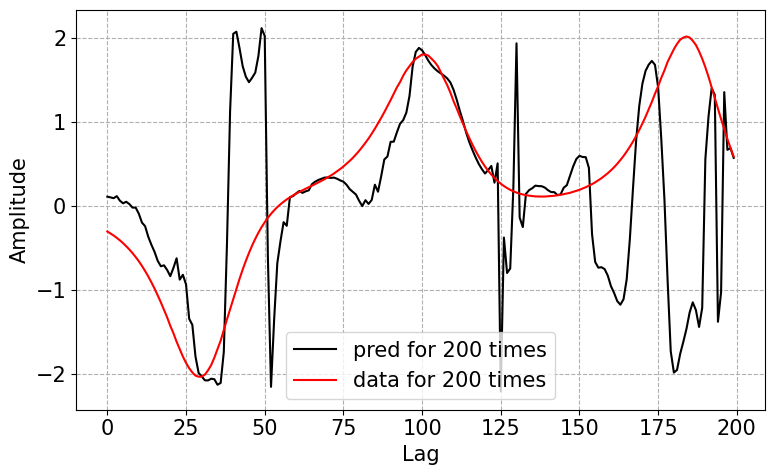

Correlation with ORIGINAL data (result): 0.3605986359466552
Forecast period: 750


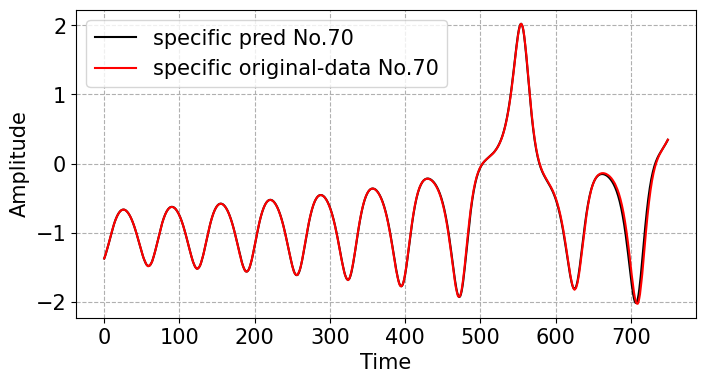

CPU times: user 4min 17s, sys: 1min 53s, total: 6min 11s
Wall time: 3min 46s


In [30]:
# @title Model evaluation

%%time

T_0 = T_train+lag*dim+T_slide

###############################
#Matrices are elected by random numbers

Wdatain    = input_matrix(N_x,seed_value_datain,input_scale,dim)
Wgatein    = make_connection(N_x, density_gate, rho_gate,seed_value_gatein)
Wdatacell  = input_matrix(N_x,seed_value_datacell,input_scale,dim)
Wcell      = make_connection(N_x, density_res, rho_res,seed_value_cell)
Wdataforget= input_matrix(N_x,seed_value_dataforget,input_scale,dim)
Wforget    = make_connection(N_x, density_gate, rho_gate,seed_value_forget)
Wdataout   = input_matrix(N_x,seed_value_dataout,input_scale,dim)
Wgateout   = make_connection(N_x, density_gate, rho_gate,seed_value_gateout)

#################
#Model evaluation

data_delay_train = np.zeros((T_train+1,dim), dtype=float)

for i in range(dim):

       data_delay_train[:,i] = data[T_0-T_train-i*lag:T_0-i*lag+1]

train_U = np.zeros((T_train,dim), dtype=float)
train_D = np.zeros((T_train,dim), dtype=float)

#Training data input
train_U = data_delay_train[:T_train,:]

#Training data output
train_D = data_delay_train[1:T_train+1,:]

#Training
X_XT, D_XT,x_special, c_special = train(train_U,train_D,np.zeros(N_x),np.zeros(N_x), T_train,Wdatain,Wgatein,Wdatacell, \
                                 Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len,gate_bias_scale,reservoir_bias_scale)

Wout= None
Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

data_delay = np.zeros((T_train+T_test+1,dim,test_num), dtype=float)

#Create test data

for t in range(test_num):

       for i in range(dim):

           data_delay[:,i,t] = data[T_0+t-T_train-i*lag
                                        :T_0+t+T_test-i*lag+1]

test_Y = np.zeros((T_test,test_num))
test_D = np.zeros((T_test,test_num))
tentative_test_Y=np.zeros((T_test,dim,test_num))


 ##Create initial cell state vector and initial hidden state vector

x_conti = None
for t in range(test_num):


    X_XT, D_XT,x_conti,c_conti =  train(data_delay[T_train-synchro_len :T_train,:,t], \
                                data_delay[T_train-synchro_len+1:T_train+1,:,t],np.zeros(N_x),np.zeros(N_x),synchro_len,Wdatain,Wgatein,Wdatacell, \
                                 Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,0,gate_bias_scale,reservoir_bias_scale)


  #Predictive data generation by induction


    tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],x_conti,c_conti,Wdatain,Wgatein,Wdatacell, \
                                  Wcell,Wdataforget,Wforget, Wdataout,Wgateout,Wout,T_test,gate_bias_scale,reservoir_bias_scale)

    test_Y[:,t] = tentative_test_Y[:,0,t]
    test_D[:,t] = data_delay[T_train+1
                             :T_train+T_test+1,0,t]


###############################
#Autocorrelation

test_Y_cor = [0]*test_num
data_delay_cor = [0]*test_num


for t in range(test_num):

    test_Y_cor[t] = test_Y[T_test-1,t]
    data_delay_cor[t] = test_D[T_test-1,t]

ac_flt = correlation(test_Y_cor[:],data_delay_cor[:])


######################
######################

print("Correlation with ORIGINAL data (result):", ac_flt)
print("Forecast period:", T_test)

fig = plt.figure(figsize=(8,5), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.plot(test_Y_cor[:], color = "black",label=f"pred for {test_num} times")
plt.plot(data_delay_cor[:], color = "red",label=f"data for {test_num} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

print("Correlation with ORIGINAL data (result):",ac_flt)
print("Forecast period:", T_test)


plt.figure(figsize=(8, 4))
plt.plot(test_Y[:,T_fix], color = "black",label=f"specific pred No.{T_fix}")
plt.plot(test_D[:,T_fix], color = "red",label=f"specific original-data No.{T_fix}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')


plt.show()